In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the dataset
train = pd.read_csv("BlackFTrain.csv")
test = pd.read_csv("BlackF1.csv")
sample_submission = pd.read_csv("BlackFSample.csv")

print(train.shape)
print(test.shape)
train.head()

(550068, 12)
(233599, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### Exploratory Data Analysis(EDA)

#### Basic Info

In [5]:

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
# Descriptive Statistics
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [7]:
# Checking for missing values
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [8]:
# Unique values in each column
train.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

#### Visualizing Target Variable(Purchase)

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


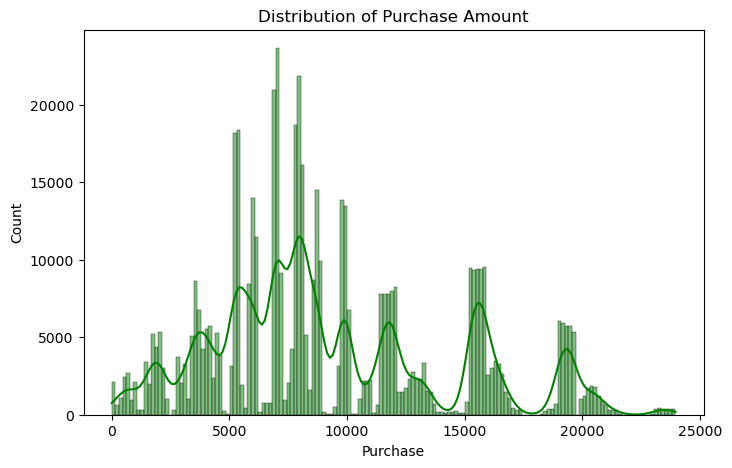

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(train['Purchase'], kde=True, color='green')
plt.title("Distribution of Purchase Amount")
plt.show()

#### Categorical Features Overview

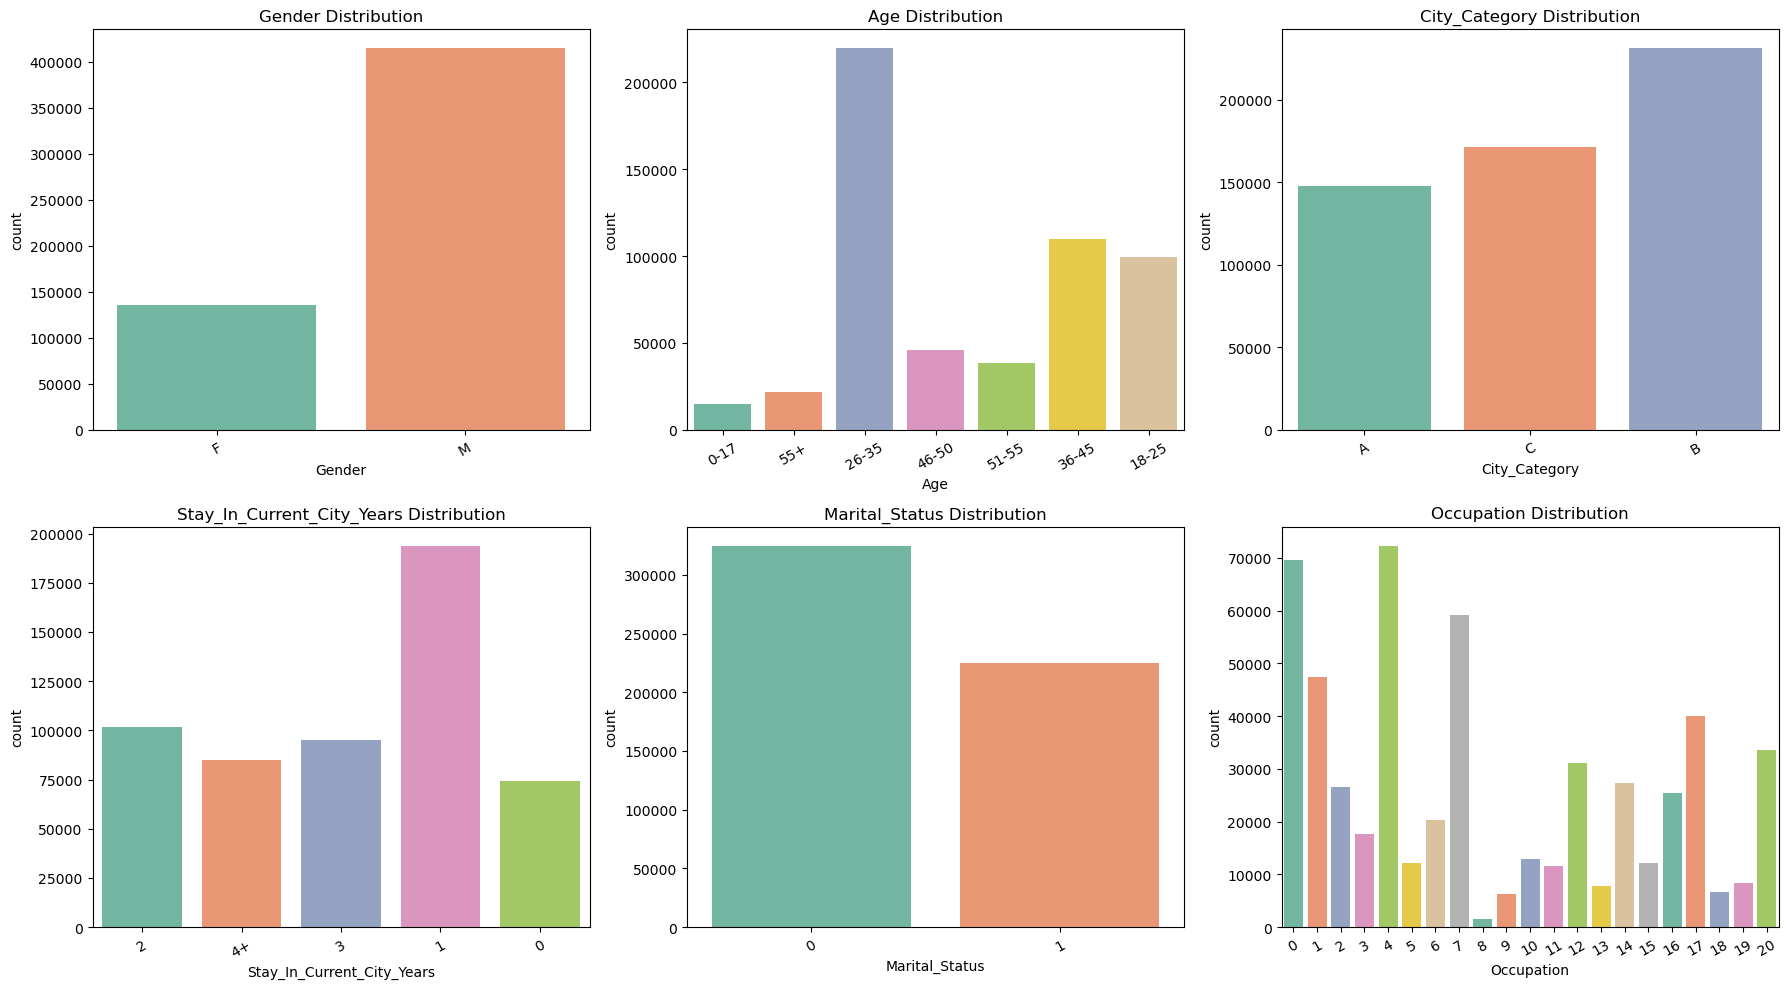

In [18]:
categorical_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Occupation']
plt.figure(figsize=(18, 10))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=train, x=col, palette='Set2')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

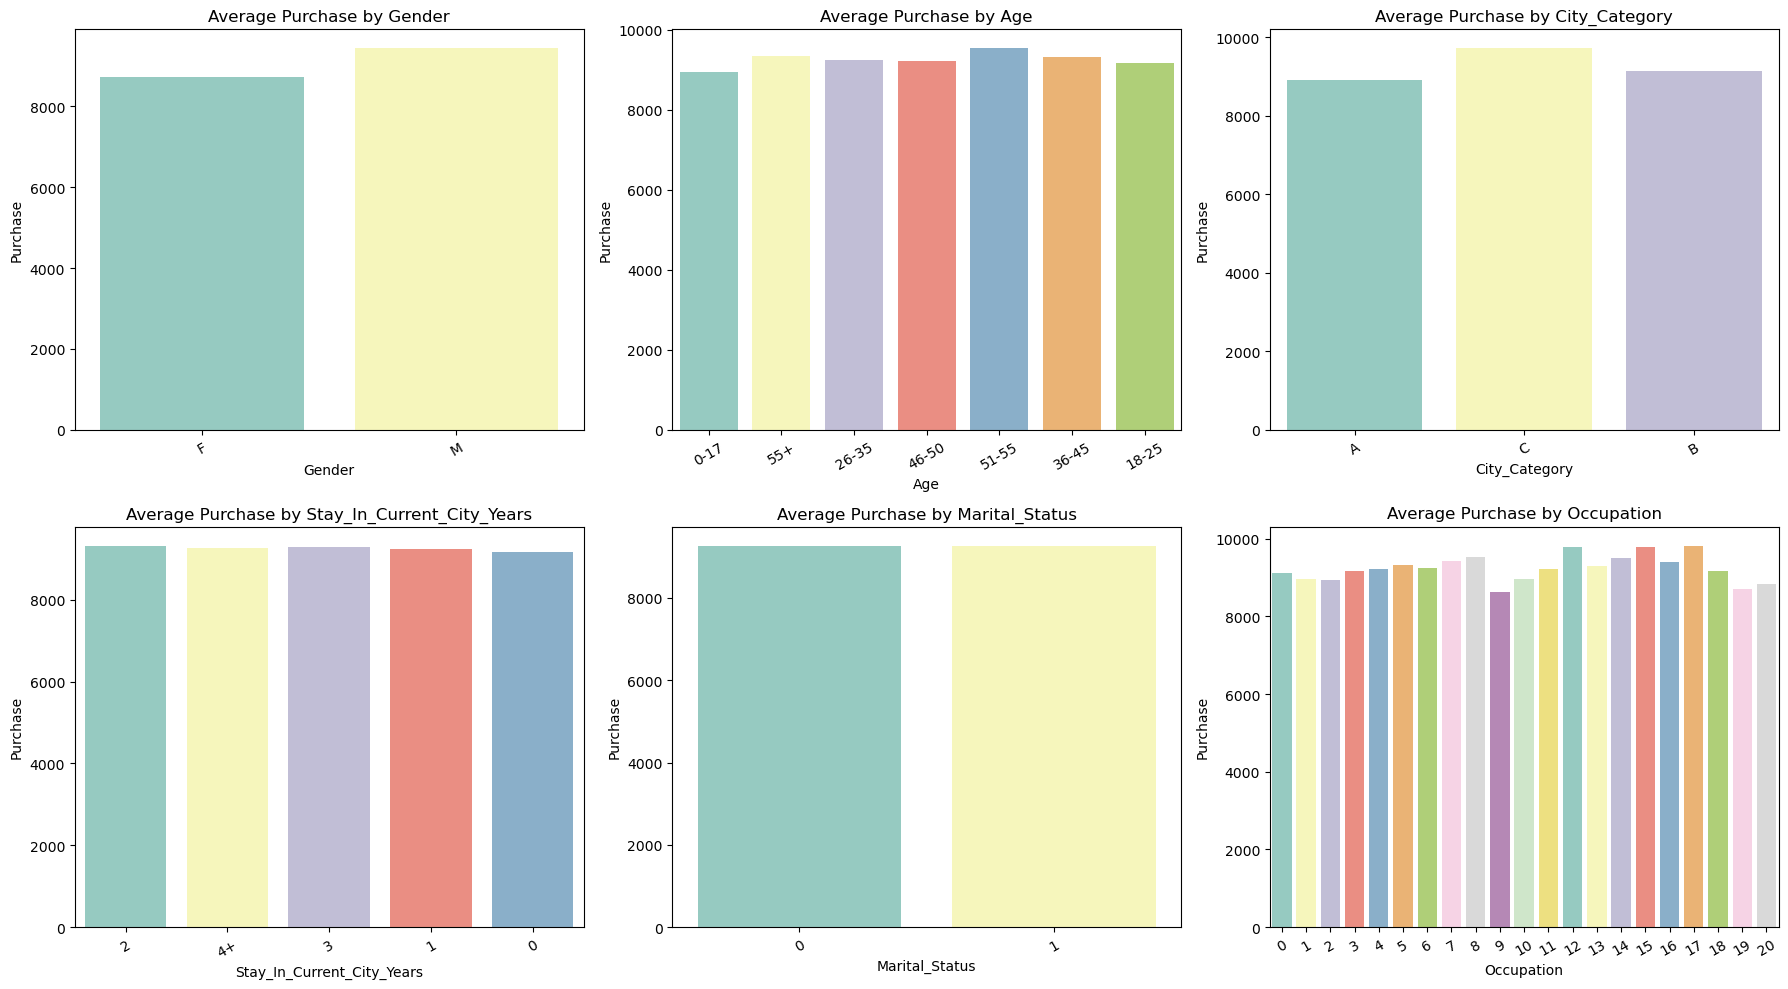

In [19]:
categorical_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Occupation']
plt.figure(figsize=(18, 10))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.barplot(data=train, x=col, y= 'Purchase', estimator= 'mean', palette='Set3', errorbar = None)
    plt.title(f'Average Purchase by {col}')
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

## errorbar/ci(by default in sns) = 95%(confidence interval : We are 95% confident the true purchase for this group lies within the range.)

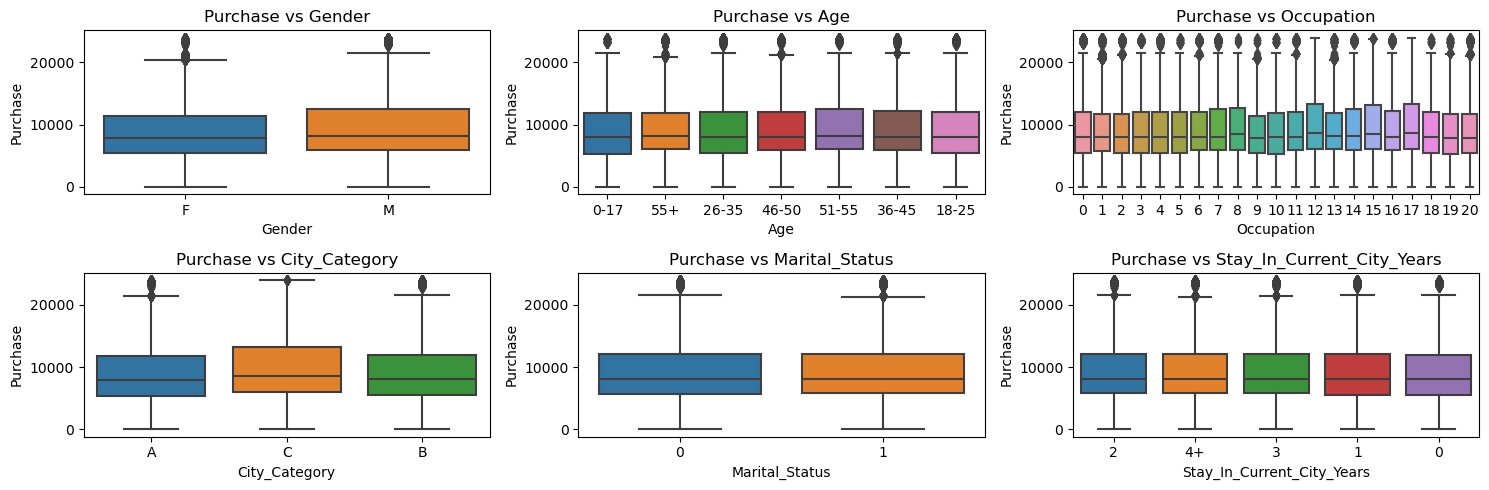

In [20]:
categorical_features = ['Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status', 'Stay_In_Current_City_Years']
plt.figure(figsize = (15, 5))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=col, y='Purchase', data = train)
    plt.title(f'Purchase vs {col}')

plt.tight_layout()
plt.show()

#### Handling Missing Values

In [23]:
# As from isnull(), we know that Product_Category_2 has 173638 and Product_Category_3 has 383247 null values and we will use mode to fill it up.
train['Product_Category_2'].fillna(train['Product_Category_2'].mode()[0], inplace=True)
train['Product_Category_3'].fillna(train['Product_Category_3'].mode()[0], inplace=True)

In [25]:
print(train.isnull().sum())

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64


## Feature Engineering

### Encoding Categorical Variables

#### Label Encoding(for Ordinal variables)

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Age has order, so we label encode
train['Age'] = le.fit_transform(train['Age'])

#Stay_In_City_Years: remove '+' sign first if present, then convert
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)
train['Stay_In_Current_City_Years'] = le.fit_transform(train['Stay_In_Current_City_Years'])

#### One-Hot Encoding(For nominal variables)

In [32]:
train = pd.get_dummies(train, columns=['Gender', 'City_Category', 'Marital_Status'], drop_first= True)
print(train.columns)

Index(['User_ID', 'Product_ID', 'Age', 'Occupation',
       'Stay_In_Current_City_Years', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'Gender_M',
       'City_Category_B', 'City_Category_C', 'Marital_Status_1'],
      dtype='object')


## Model Building

### Linear Regression

In [39]:
# Define features(X) and target (y)
X = train.drop(['User_ID', 'Product_ID', 'Purchase'], axis=1)
y = train['Purchase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
# Evaluate the model
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse : .2f}")
print(f"R^2 Score: {r2 : .4f}")

Mean Squared Error:  21849890.00
R^2 Score:  0.1304


<p> As we can see that the Linear Regression Model is giving us an R^2 of ).1304 and MSE of 21849890, thus RMSE = Root(MSE) = 4674.
That means the model is <b>off by ~4674 units of purchase amount</b> on average, which is quit large considering most purchase values are
between <b>0 and 20,000</b>.</p>
<p><b>Low R^2 + High MSE = Underfitting</b>-> The linear model is too simple for the data.</p>
<p>The next step would be trying non-linear model like Random Forest which can capture complex patterns better.</p>

### Random Forest Regressor

In [52]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, max_depth = 10, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest MSE : {mse_rf: .2f}")
print(f"Random Forest RMSE : {rmse_rf: .2f}")
print(f"Random Forest R^2 Score: {r2_rf: .4f}")

Random Forest MSE :  8774593.97
Random Forest RMSE :  2962.19
Random Forest R^2 Score:  0.6508


## Predicting on the test dataset

In [56]:
print(test.columns)

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object')


In [61]:
# Fill missing values
test['Product_Category_2'].fillna(train['Product_Category_2'].mode()[0], inplace=True)
test['Product_Category_3'].fillna(train['Product_Category_3'].mode()[0], inplace=True)

# Drop unnecessary columns if done in the training
test.drop(['User_ID', 'Product_ID'], axis = 1, inplace = True)
# One-Hot Encoding(must match training!)
test = pd.get_dummies(test, drop_first = True)

In [63]:
# Align columns with Training data
test = test.reindex(columns= X_train.columns, fill_value = 0)

In [65]:
# Predict
test_predictions = rf_model.predict(test)

In [67]:
# Creating Submission file
sample_submission['Purchase'] = test_predictions
sample_submission.to_csv("Final_submission.csv", index = False)

## Saving the Trained model using pickle

In [76]:
import pickle

#Save to file
with open('random_forest_model.pkl', 'wb') as file: 
    pickle.dump(rf_model, file)

In [78]:
with open('random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)